In [208]:
from os import path
import requests
from requests.auth import HTTPBasicAuth
import pandas as pd

import numpy as np

from datetime import datetime, timezone
from dateutil import tz
import pytz

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

## All units are kWH

In [190]:
res = pd.read_csv("alameda-county-2018-amy-aggregate-restock.csv")
res["Timestamp (PST)"] = pd.DatetimeIndex(res['Timestamp (EST)']).tz_convert("America/Los_Angeles")
res = res.drop(columns="Timestamp (EST)")
res["month"] = [t.month for t in res["Timestamp (PST)"]]
res["day"] = [t.day for t in res["Timestamp (PST)"]]
res["hour"] = [t.hour for t in res["Timestamp (PST)"]]
res.columns

Index(['baseline.out.electricity.ceiling_fan.energy_consumption.kwh',
       'baseline.out.electricity.clothes_dryer.energy_consumption.kwh',
       'baseline.out.electricity.clothes_washer.energy_consumption.kwh',
       'baseline.out.electricity.cooling_fans_pumps.energy_consumption.kwh',
       'baseline.out.electricity.cooling.energy_consumption.kwh',
       'baseline.out.electricity.dishwasher.energy_consumption.kwh',
       'baseline.out.electricity.freezer.energy_consumption.kwh',
       'baseline.out.electricity.heating_fans_pumps.energy_consumption.kwh',
       'baseline.out.electricity.heating_hp_bkup.energy_consumption.kwh',
       'baseline.out.electricity.heating.energy_consumption.kwh',
       'baseline.out.electricity.hot_tub_heater.energy_consumption.kwh',
       'baseline.out.electricity.hot_tub_pump.energy_consumption.kwh',
       'baseline.out.electricity.hot_water.energy_consumption.kwh',
       'baseline.out.electricity.lighting_exterior.energy_consumption.kwh',
  

In [191]:
res

,baseline.out.electricity.ceiling_fan.energy_consumption.kwh,baseline.out.electricity.clothes_dryer.energy_consumption.kwh,baseline.out.electricity.clothes_washer.energy_consumption.kwh,baseline.out.electricity.cooling_fans_pumps.energy_consumption.kwh,baseline.out.electricity.cooling.energy_consumption.kwh,baseline.out.electricity.dishwasher.energy_consumption.kwh,baseline.out.electricity.freezer.energy_consumption.kwh,baseline.out.electricity.heating_fans_pumps.energy_consumption.kwh,baseline.out.electricity.heating_hp_bkup.energy_consumption.kwh,baseline.out.electricity.heating.energy_consumption.kwh,...,baseline.out.site_energy.total.energy_consumption.kwh,baseline.out.electricity.total.energy_consumption.kwh,baseline.out.fuel_oil.total.energy_consumption.kwh,baseline.out.natural_gas.total.energy_consumption.kwh,baseline.out.propane.total.energy_consumption.kwh,baseline.upgrade.kwh,Timestamp (PST),month,day,hour
0,1617.677296,7410.661776,625.666537,113.559445,505.085293,1700.728233,621.792441,1898.307140,0.0,12919.142315,...,353765.761955,130701.110015,0.0,219831.286435,3226.410839,0,2017-12-31 21:15:00-08:00,12,31,21
1,1609.929104,6227.367516,620.581786,95.641750,435.835823,1543.585206,621.792441,2020.099039,0.0,13376.769929,...,362403.774989,129495.297572,0.0,229235.258925,3666.088881,0,2017-12-31 21:30:00-08:00,12,31,21
2,1549.638481,6572.888471,619.855393,82.566675,381.598476,1292.011084,621.792441,2167.314695,0.0,14515.269951,...,363035.120300,128291.906438,0.0,231627.871023,3109.395169,0,2017-12-31 21:45:00-08:00,12,31,21
3,1521.309153,7766.594364,483.777763,74.818483,347.700134,1164.650171,621.792441,2297.096918,0.0,15436.578454,...,365628.340827,130123.143288,0.0,231164.988539,4338.166148,0,2017-12-31 22:00:00-08:00,12,31,22
4,1181.357211,6949.402196,390.073062,125.665996,478.208750,991.284366,621.792441,2416.225376,0.0,16762.245749,...,358834.477723,114756.782827,0.0,239331.603697,4744.350317,0,2017-12-31 22:15:00-08:00,12,31,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,1654.965472,7712.114886,616.949820,86.682903,459.080400,2372.883925,699.516496,1540.921765,0.0,10394.684376,...,367859.302411,155724.865918,0.0,208559.108034,3576.535349,0,2018-12-31 20:00:00-08:00,12,31,20
35036,1698.549054,6740.443132,638.257350,102.421418,497.337100,2203.150085,699.516496,1604.117959,0.0,10440.931400,...,349968.819893,140017.100730,0.0,206849.430326,3107.975937,0,2018-12-31 20:15:00-08:00,12,31,20
35037,1703.391675,6364.655801,598.547863,85.956510,441.162705,2030.510673,699.516496,1658.597437,0.0,10859.575921,...,348508.501230,141611.533449,0.0,203922.122610,2979.038719,0,2018-12-31 20:30:00-08:00,12,31,20
35038,1688.621683,5909.207366,441.889098,87.651427,442.131229,1739.469195,699.516496,1744.311816,0.0,11389.358577,...,360949.842870,140597.730898,0.0,217861.179673,2501.892954,0,2018-12-31 20:45:00-08:00,12,31,20


Here, I remove all the energy readings that don't come from the power grid.

In [200]:
res_electricity = res[[col for col in res.columns if "baseline.out.electricity" in col]]
res_electricity = res_electricity.rename(columns=dict(zip(res_electricity.columns, [c[25:-23] for c in res_electricity.columns])))
res_electricity

,ceiling_fan,clothes_dryer,clothes_washer,cooling_fans_pumps,cooling,dishwasher,freezer,heating_fans_pumps,heating_hp_bkup,heating,...,lighting_garage,lighting_interior,mech_vent,plug_loads,pool_heater,pool_pump,range_oven,refrigerator,well_pump,total
0,1617.677296,7410.661776,625.666537,113.559445,505.085293,1700.728233,621.792441,1898.307140,0.0,12919.142315,...,260.048708,26570.973075,343.099645,50634.437382,4.600489,313.075399,2127.605209,9219.138310,1876.999611,130701.110015
1,1609.929104,6227.367516,620.581786,95.641750,435.835823,1543.585206,621.792441,2020.099039,0.0,13376.769929,...,260.048708,26355.476473,343.099645,50560.587423,4.600489,313.075399,2236.806296,9219.138310,1876.999611,129495.297572
2,1549.638481,6572.888471,619.855393,82.566675,381.598476,1292.011084,621.792441,2167.314695,0.0,14515.269951,...,260.048708,25325.935407,343.099645,49536.857501,4.600489,313.075399,2002.423475,9219.138310,1876.999611,128291.906438
3,1521.309153,7766.594364,483.777763,74.818483,347.700134,1164.650171,621.792441,2297.096918,0.0,15436.578454,...,260.048708,24708.259194,343.099645,49065.912681,4.600489,313.075399,1781.842123,9219.138310,1876.999611,130123.143288
4,1181.357211,6949.402196,390.073062,125.665996,478.208750,991.284366,621.792441,2416.225376,0.0,16762.245749,...,232.930034,18288.639653,306.537862,42858.399908,4.600489,313.075399,1344.311383,8876.522927,1640.195480,114756.782827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,1654.965472,7712.114886,616.949820,86.682903,459.080400,2372.883925,699.516496,1540.921765,0.0,10394.684376,...,260.048708,44433.704277,468.765641,56089.649098,12.348682,851.816903,3204.361822,9681.850675,1662.471533,155724.865918
35036,1698.549054,6740.443132,638.257350,102.421418,497.337100,2203.150085,699.516496,1604.117959,0.0,10440.931400,...,301.695242,36532.485069,415.254687,53318.701789,5.811144,418.644521,2690.559813,9587.903842,1769.251310,140017.100730
35037,1703.391675,6364.655801,598.547863,85.956510,441.162705,2030.510673,699.516496,1658.597437,0.0,10859.575921,...,301.695242,36826.189988,415.254687,53556.474443,5.811144,418.644521,2224.699745,9587.903842,1769.251310,141611.533449
35038,1688.621683,5909.207366,441.889098,87.651427,442.131229,1739.469195,699.516496,1744.311816,0.0,11389.358577,...,301.695242,36507.545575,415.254687,53342.672759,5.811144,418.644521,2183.779604,9587.903842,1769.251310,140597.730898


In [201]:
means = res_electricity.mean().sort_values()[:-1] # getting rid of the total column

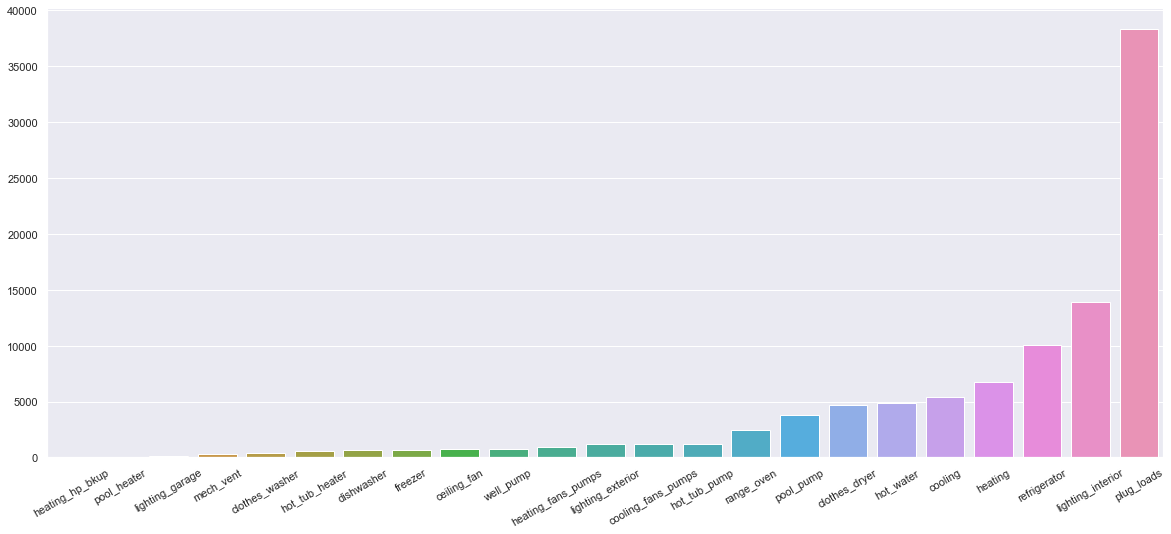

In [202]:
sns.set(rc={'figure.figsize':(20,8.27)})
sns.barplot(x=means.index, y=means)
plt.xticks(rotation=30);

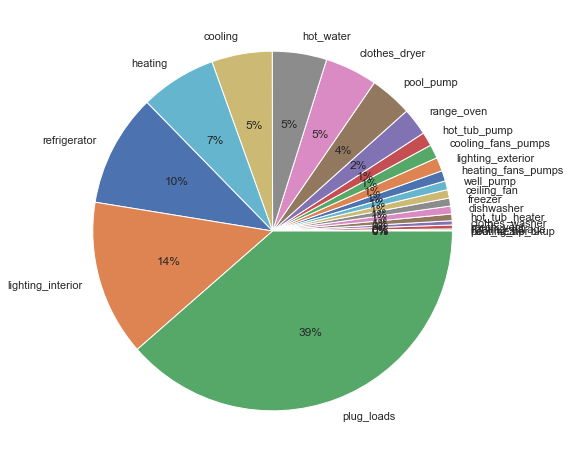

In [203]:
plt.pie(means, labels = means.index, autopct='%.0f%%');

In [204]:
df = res_electricity
df["Timestamp (PST)"] = res["Timestamp (PST)"]
df["month"] = res["month"]
df["hour"] = res["hour"]
df = df.drop(columns="total")
df

,ceiling_fan,clothes_dryer,clothes_washer,cooling_fans_pumps,cooling,dishwasher,freezer,heating_fans_pumps,heating_hp_bkup,heating,...,mech_vent,plug_loads,pool_heater,pool_pump,range_oven,refrigerator,well_pump,Timestamp (PST),month,hour
0,1617.677296,7410.661776,625.666537,113.559445,505.085293,1700.728233,621.792441,1898.307140,0.0,12919.142315,...,343.099645,50634.437382,4.600489,313.075399,2127.605209,9219.138310,1876.999611,2017-12-31 21:15:00-08:00,12,21
1,1609.929104,6227.367516,620.581786,95.641750,435.835823,1543.585206,621.792441,2020.099039,0.0,13376.769929,...,343.099645,50560.587423,4.600489,313.075399,2236.806296,9219.138310,1876.999611,2017-12-31 21:30:00-08:00,12,21
2,1549.638481,6572.888471,619.855393,82.566675,381.598476,1292.011084,621.792441,2167.314695,0.0,14515.269951,...,343.099645,49536.857501,4.600489,313.075399,2002.423475,9219.138310,1876.999611,2017-12-31 21:45:00-08:00,12,21
3,1521.309153,7766.594364,483.777763,74.818483,347.700134,1164.650171,621.792441,2297.096918,0.0,15436.578454,...,343.099645,49065.912681,4.600489,313.075399,1781.842123,9219.138310,1876.999611,2017-12-31 22:00:00-08:00,12,22
4,1181.357211,6949.402196,390.073062,125.665996,478.208750,991.284366,621.792441,2416.225376,0.0,16762.245749,...,306.537862,42858.399908,4.600489,313.075399,1344.311383,8876.522927,1640.195480,2017-12-31 22:15:00-08:00,12,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,1654.965472,7712.114886,616.949820,86.682903,459.080400,2372.883925,699.516496,1540.921765,0.0,10394.684376,...,468.765641,56089.649098,12.348682,851.816903,3204.361822,9681.850675,1662.471533,2018-12-31 20:00:00-08:00,12,20
35036,1698.549054,6740.443132,638.257350,102.421418,497.337100,2203.150085,699.516496,1604.117959,0.0,10440.931400,...,415.254687,53318.701789,5.811144,418.644521,2690.559813,9587.903842,1769.251310,2018-12-31 20:15:00-08:00,12,20
35037,1703.391675,6364.655801,598.547863,85.956510,441.162705,2030.510673,699.516496,1658.597437,0.0,10859.575921,...,415.254687,53556.474443,5.811144,418.644521,2224.699745,9587.903842,1769.251310,2018-12-31 20:30:00-08:00,12,20
35038,1688.621683,5909.207366,441.889098,87.651427,442.131229,1739.469195,699.516496,1744.311816,0.0,11389.358577,...,415.254687,53342.672759,5.811144,418.644521,2183.779604,9587.903842,1769.251310,2018-12-31 20:45:00-08:00,12,20


<AxesSubplot:xlabel='Timestamp (PST)', ylabel='plug_loads'>

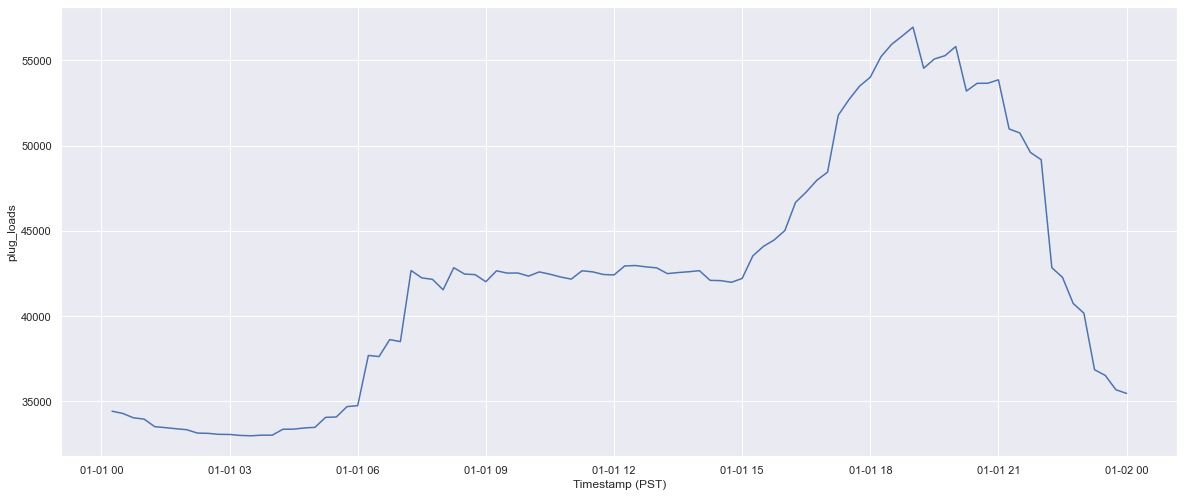

In [207]:
sns.lineplot(x=df["Timestamp (PST)"], y=df.iloc[12:108, ]["plug_loads"])

# How does energy usage breakdown by month?

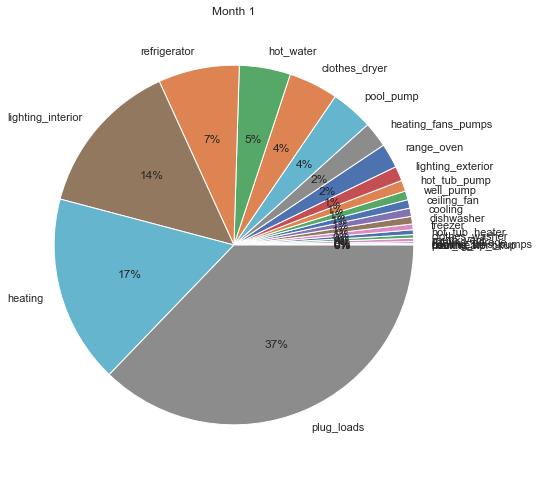

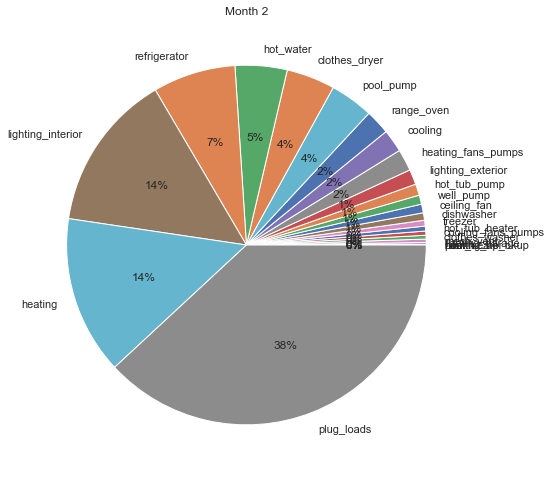

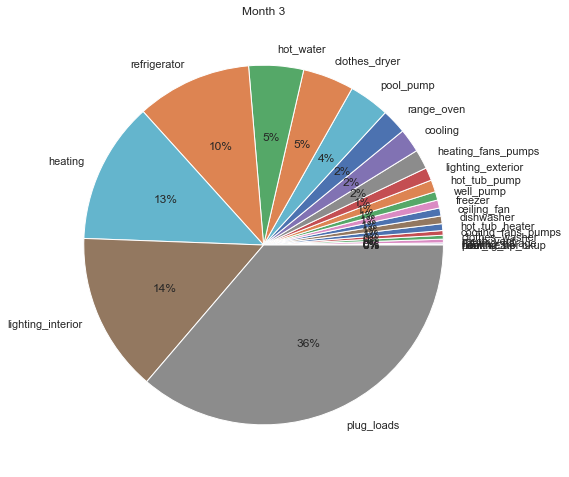

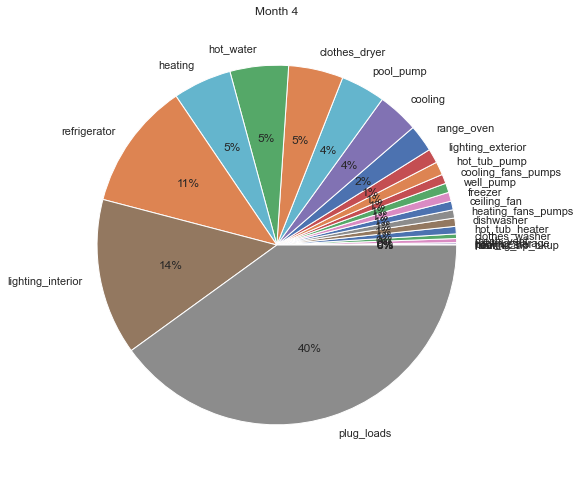

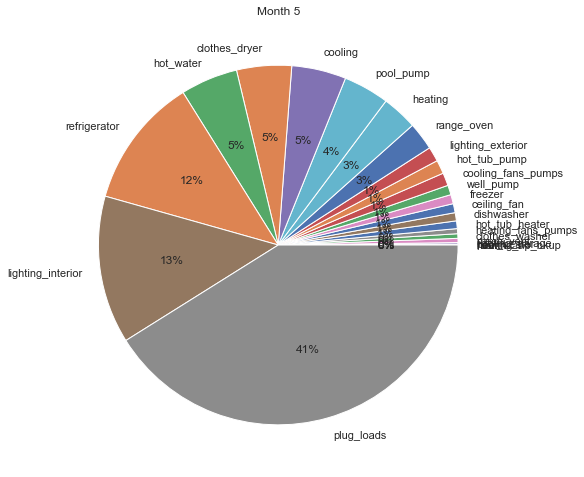

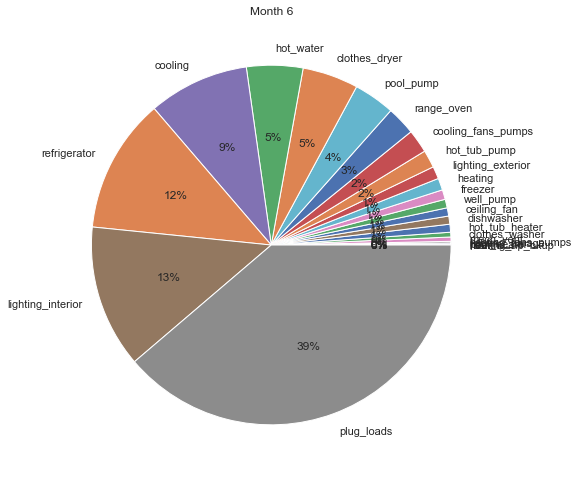

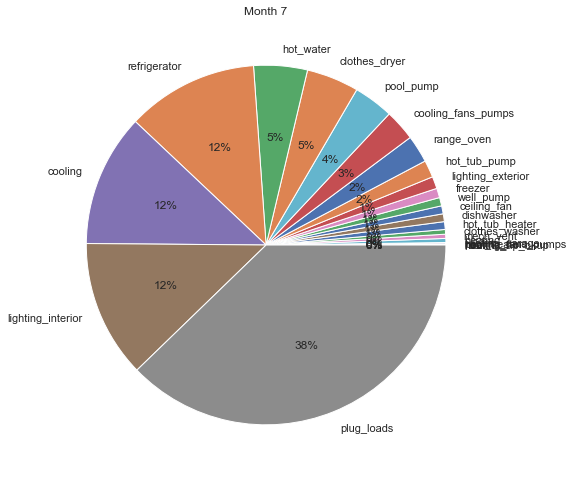

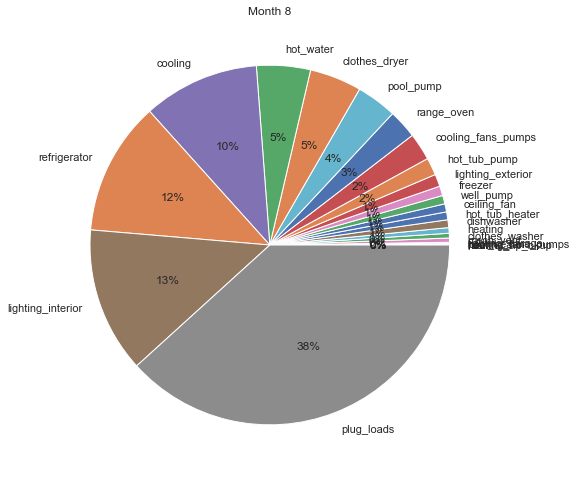

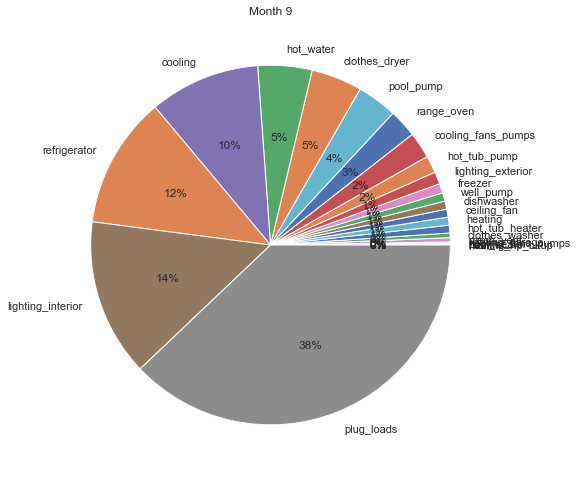

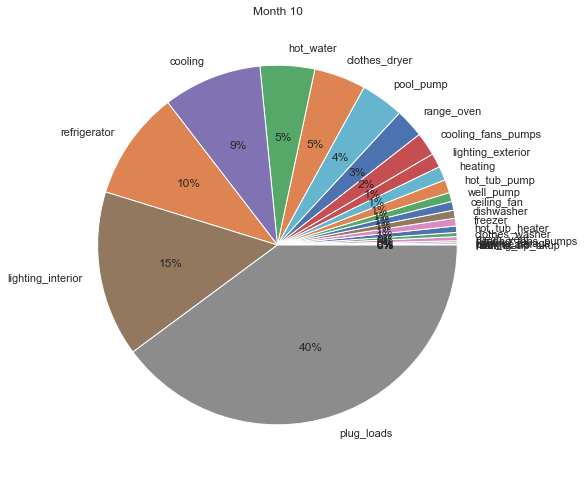

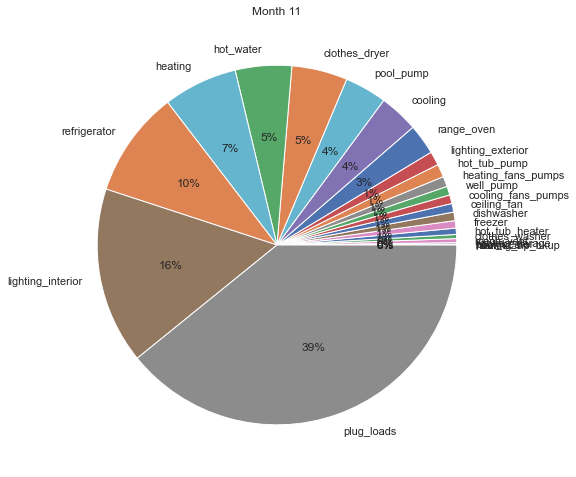

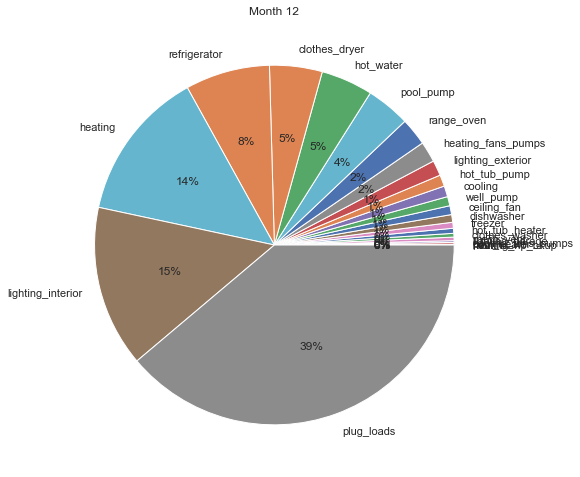

In [205]:
for i in range(1, 13):
    month_means = df[df["month"] == i].mean()
    to_plot = pd.DataFrame({"mean": month_means, "color" : sns.color_palette() + sns.color_palette() + sns.color_palette()[:5]})
    to_plot = to_plot.sort_values(by="mean")
    #print(month_means)
    plt.pie(to_plot["mean"], labels = to_plot.index, colors = to_plot["color"], autopct='%.0f%%')
    plt.title("Month " + str(i))
    plt.show()

In [198]:
df = res_electricity
df["month"] = res["month"]
df["day"] = res["day"]
group_by_day = df.groupby(["month", "day"]).mean()
group_by_day["date"] = pd.date_range(start='1/1/2018', end='12/31/2018', periods=365).tolist()
group_by_day

ceiling_fan  clothes_dryer  clothes_washer  cooling_fans_pumps  \
month day                                                                   
1     1     869.479856    5356.954447      374.990317           88.889826   
      2     879.096997    5013.857325      355.455893           33.376247   
      3     874.211499    4774.447763      336.209000           21.794313   
      4     873.848303    4795.538384      330.155725          100.393571   
      5     872.736013    5181.835715      375.653655           62.578256   
...                ...            ...             ...                 ...   
12    27    870.672855    4747.651931      329.613452          185.959140   
      28    874.297254    4785.008207      359.004626          232.153197   
      29    892.444469    6191.895323      398.928499          176.707718   
      30    890.436799    5458.742794      396.386123          155.881928   
      31    877.026272    4953.894588      363.443694           94.804380   

               cooling  dishwasher     freezer  heating_fans_pumps  \
month day                                                            
1     1     887.896946  771.863225  589.407418         2125.317575   
      2     581.005976  804.359224  589.407418         2588.741200   
      3     393.911847  821.399194  589.407418         3452.261102   
      4     589.556227  803.135958  589.407418         1690.858872   
      5     427.921165  729.697118  589.407418         1562.241905   
...                ...         ...         ...                 ...   
12    27   1268.552120  744.658796  589.407418         2336.443207   
      28   1260.087623  839.306800  589.407418         1704.824283   
      29   1405.676461  691.377363  589.407418         3038.408757   
      30   1253.708984  713.017822  589.407418         2488.983223   
      31    898.124459  832.774308  589.407418         2792.358249   

           heating_hp_bkup       heating  ...  mech_vent    plug_loads  \
month day                                 ...                            
1     1                0.0  15519.493193  ...  349.32443  42368.561302   
      2                0.0  18905.715584  ...  349.32443  42501.170909   
      3                0.0  25431.673516  ...  349.32443  42372.271456   
      4                0.0  12549.433481  ...  349.32443  42367.032850   
      5                0.0  11232.379492  ...  349.32443  42340.789380   
...                    ...           ...  ...        ...           ...   
12    27               0.0  17073.570743  ...  349.32443  42342.138756   
      28               0.0  12217.772004  ...  349.32443  42370.755615   
      29               0.0  22354.402731  ...  349.32443  43609.535709   
      30               0.0  18273.486287  ...  349.32443  43611.091905   
      31               0.0  20103.179551  ...  349.32443  42453.786375   

           pool_heater    pool_pump   range_oven  refrigerator   well_pump  \
month day                                                                    
1     1      63.549302  4363.917154  2504.759572   8376.219722  913.873064   
      2      63.549302  4363.917154  2587.570900   8376.219722  913.873064   
      3      63.549302  4363.917154  2446.829727   8376.219722  913.873064   
      4      63.549302  4363.917154  2453.659839   8376.219722  913.873064   
      5      63.549302  4363.917154  2616.606444   8376.219722  913.873064   
...                ...          ...          ...           ...         ...   
12    27     63.549302  4363.917154  2504.608240   8376.219722  913.873064   
      28     63.549302  4363.917154  2750.590649   8376.219722  913.873064   
      29     63.549302  4363.917154  2792.333027   8376.219722  913.873064   
      30     63.549302  4363.917154  2606.492430   8376.219722  913.873064   
      31     63.549302  4363.917154  2737.621507   8376.219722  913.873064   

                   total  hour       date  
month day                                  
1     1    110100.959082  11.5 2

# How does appliance usage vary over time?

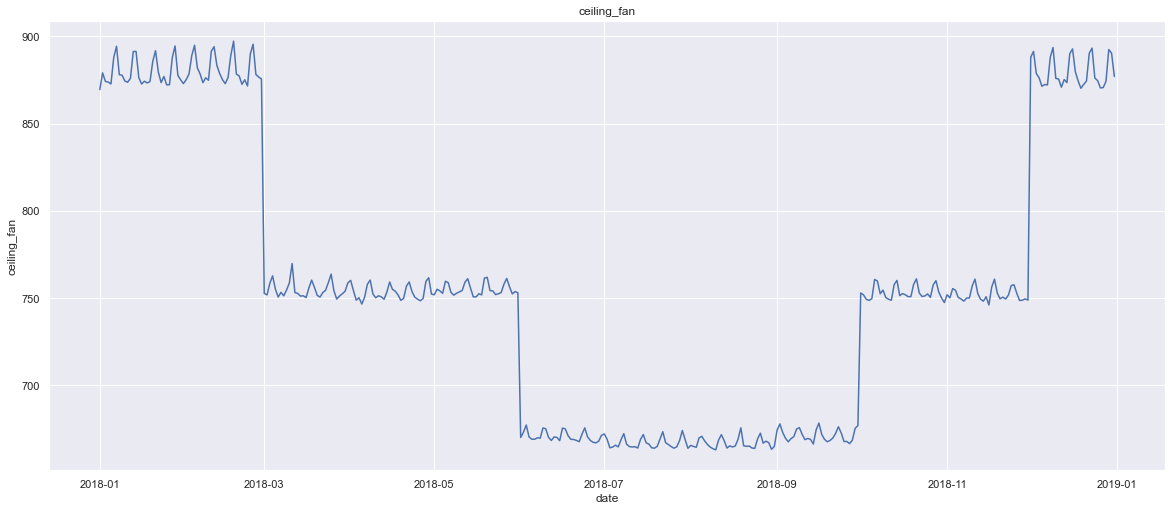

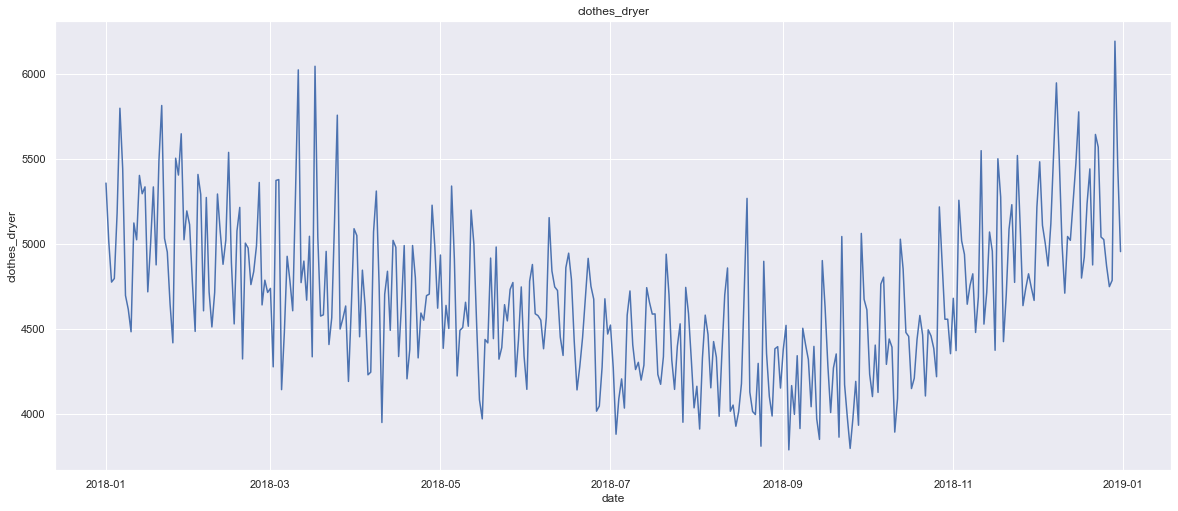

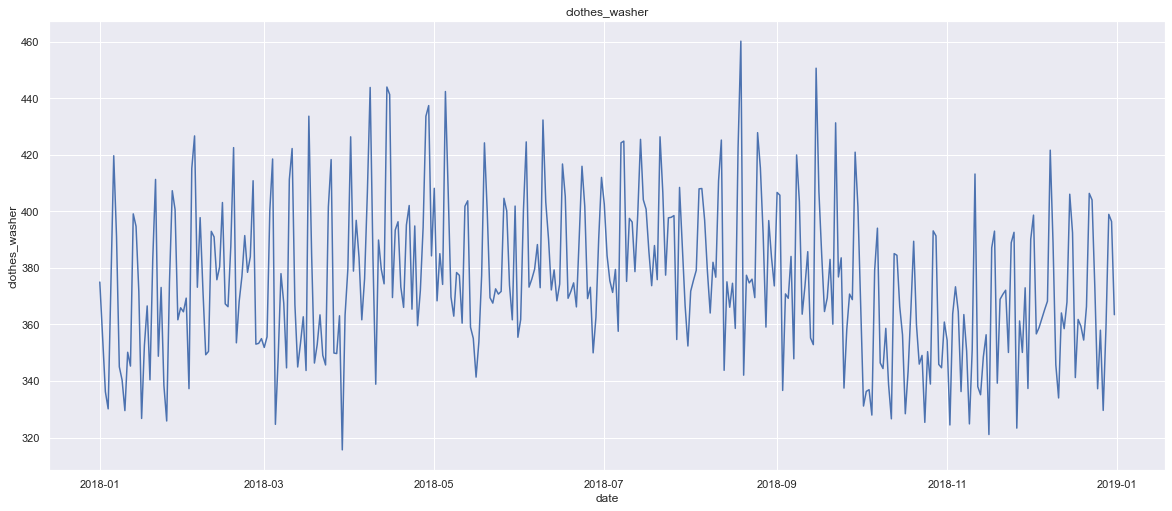

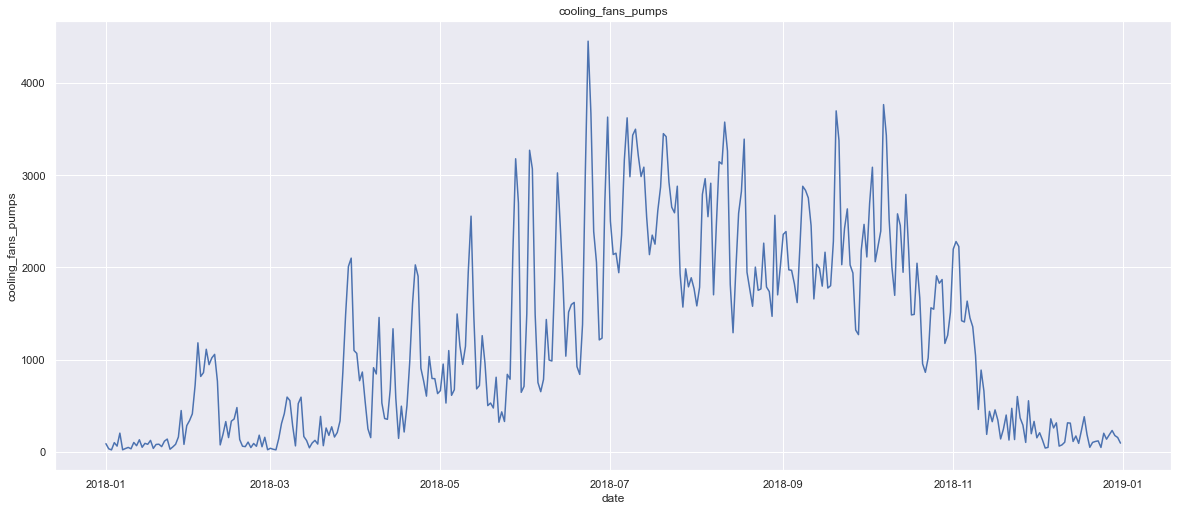

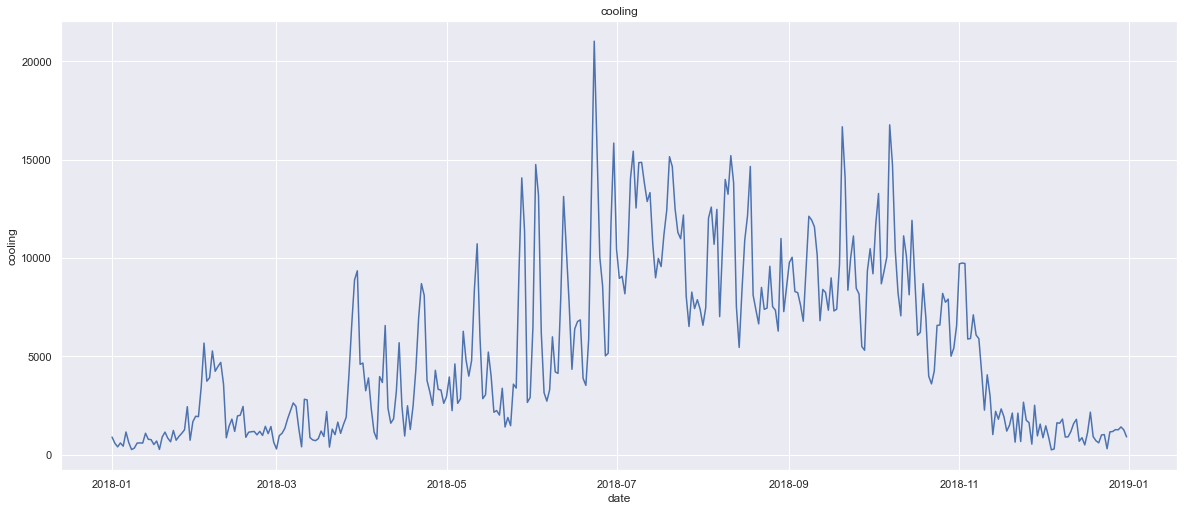

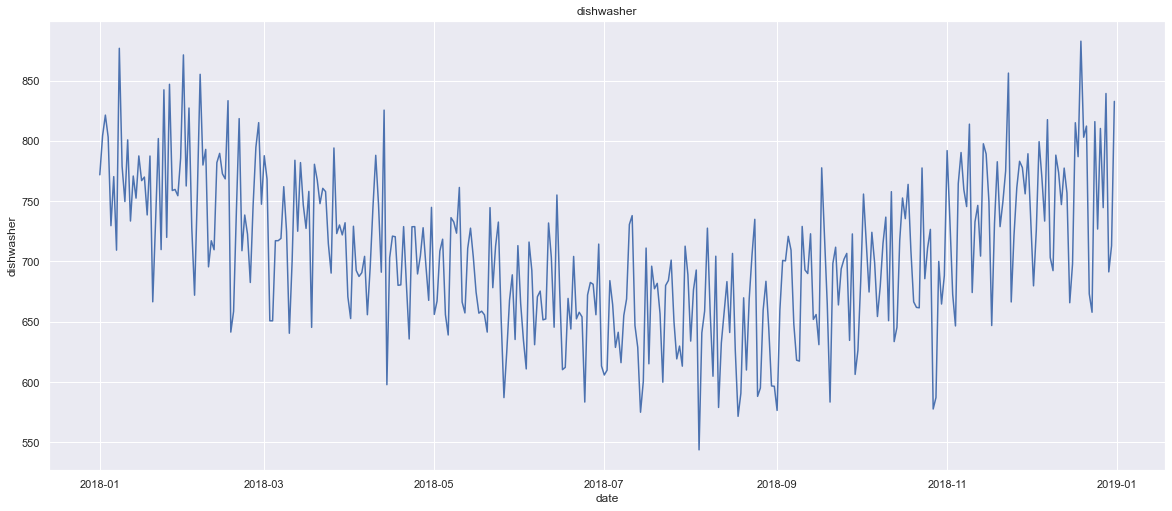

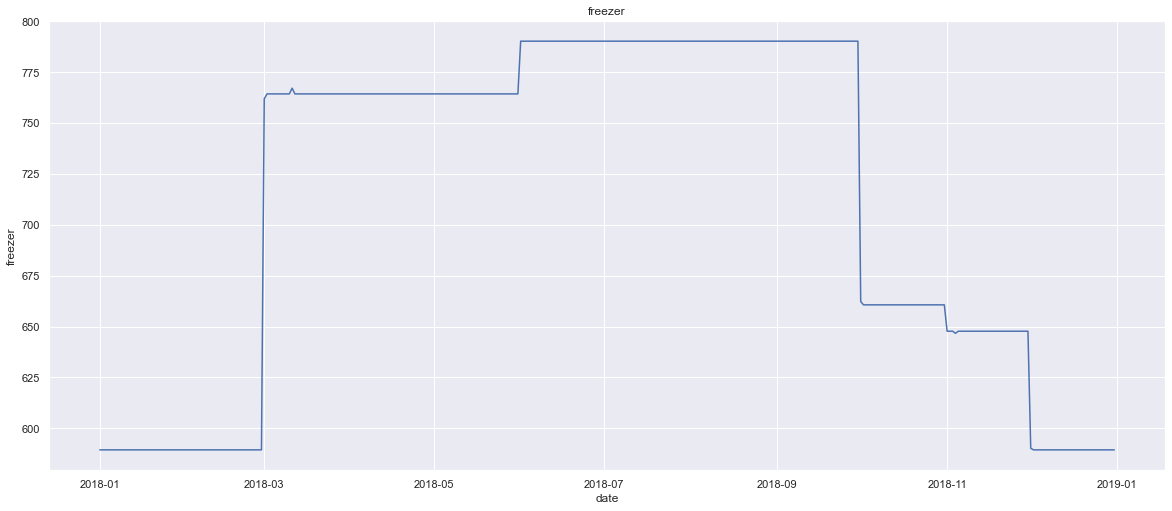

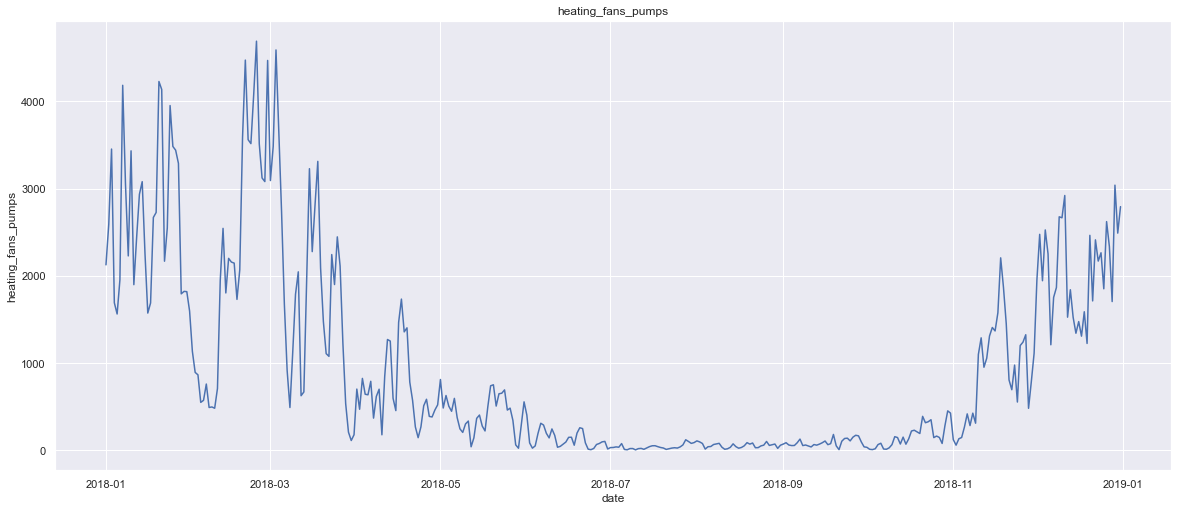

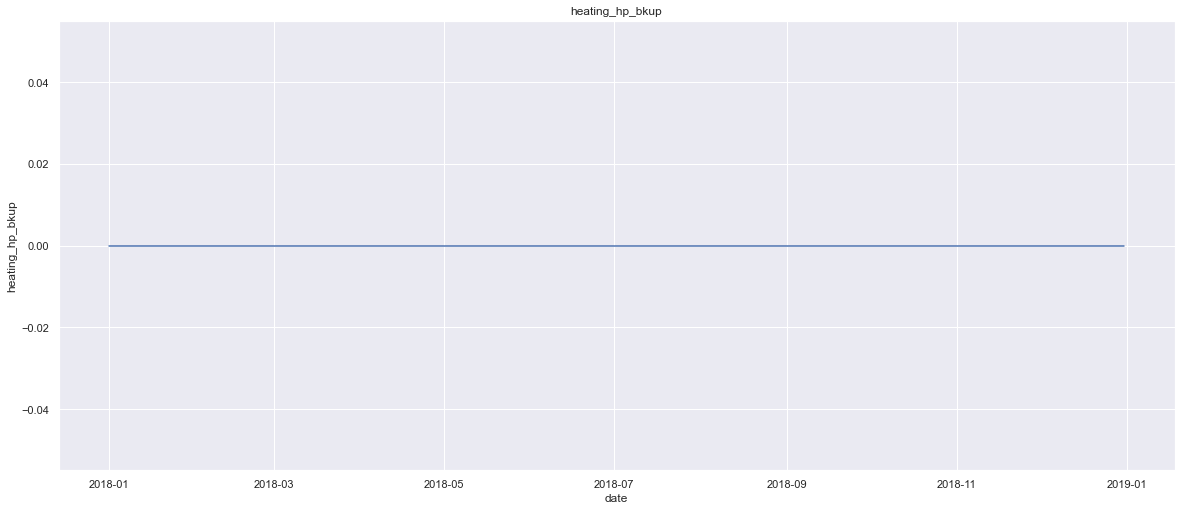

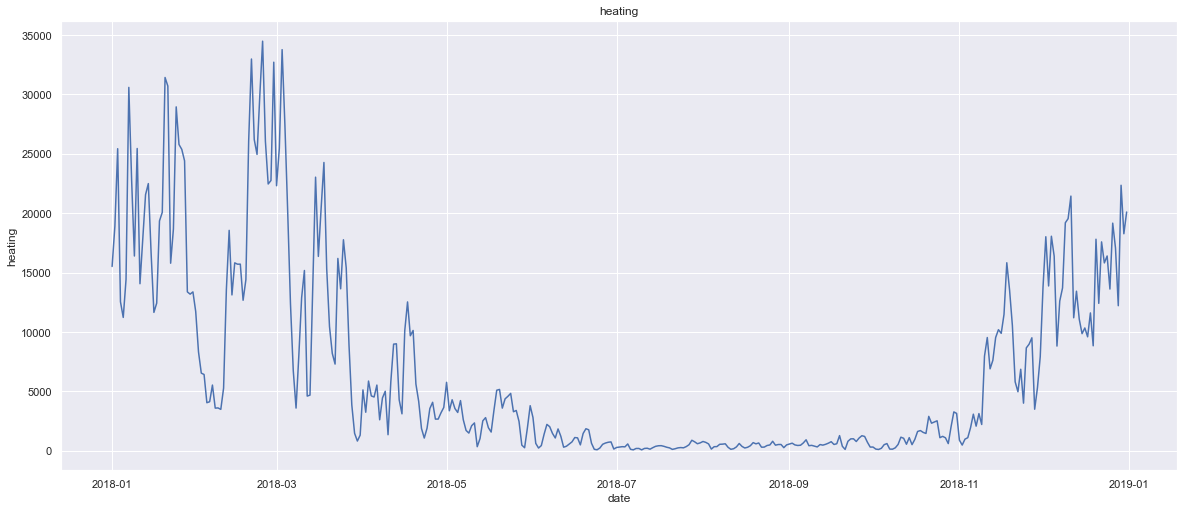

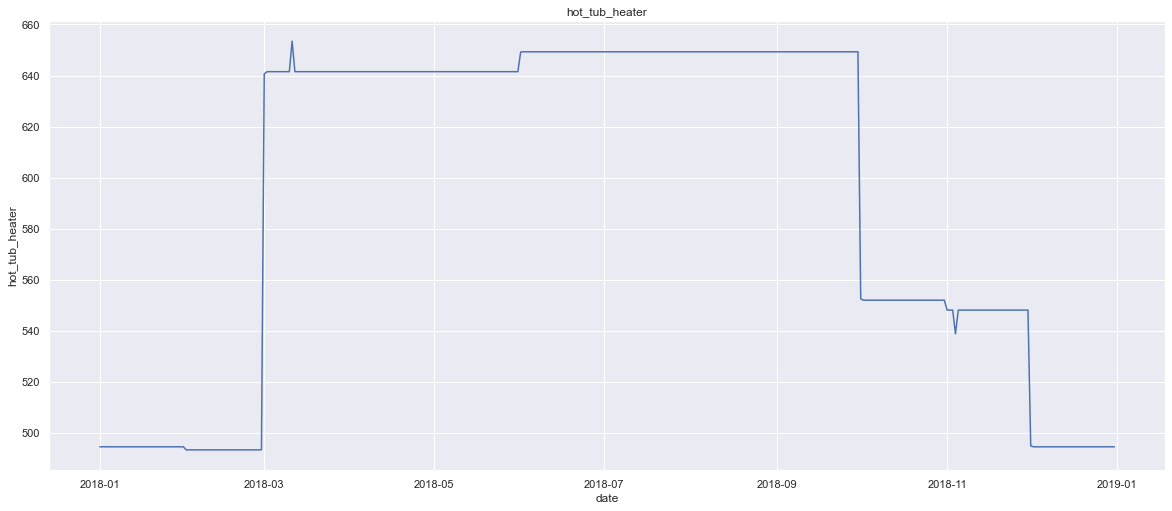

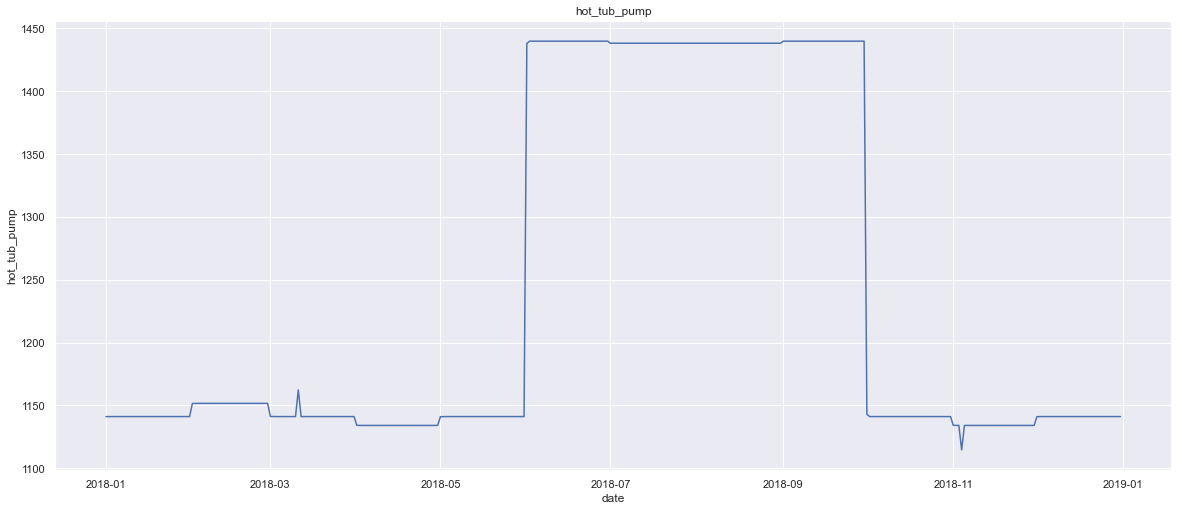

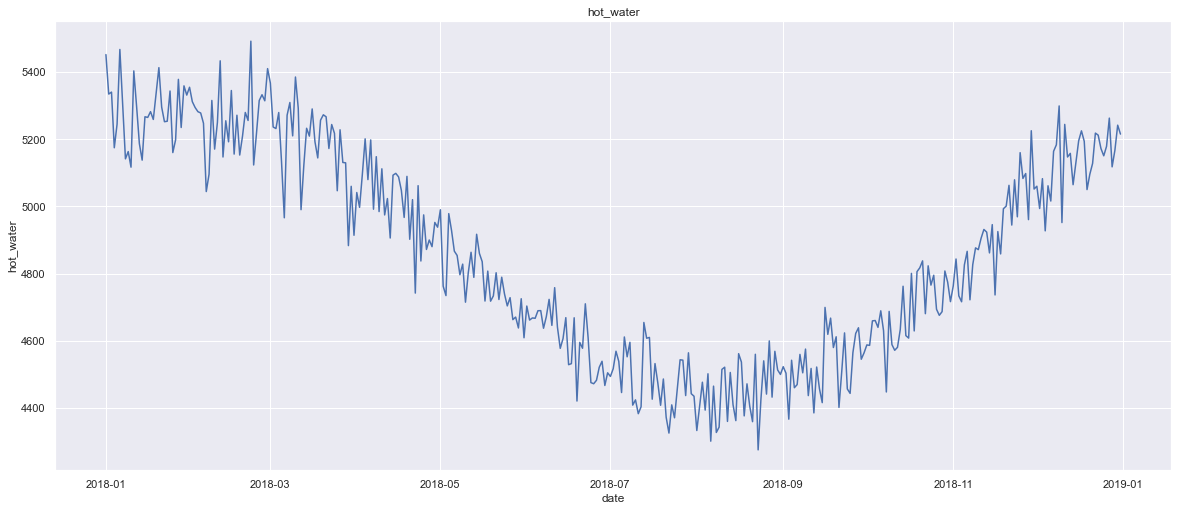

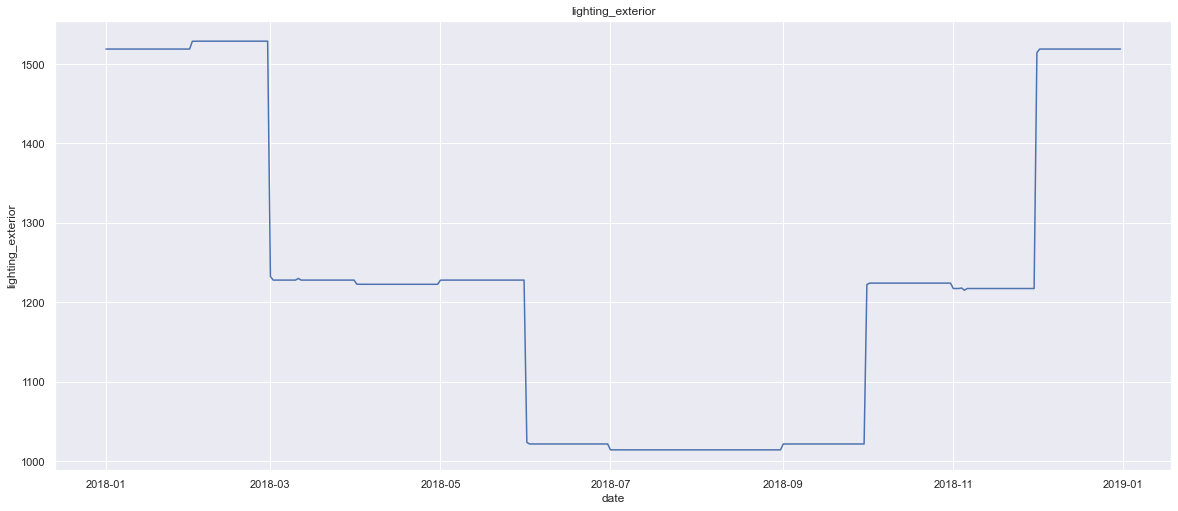

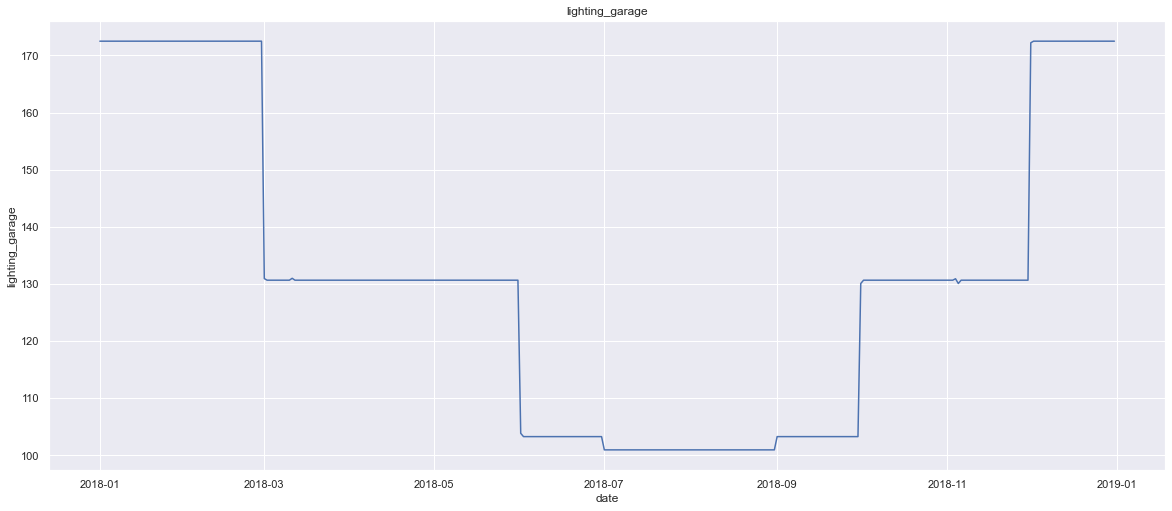

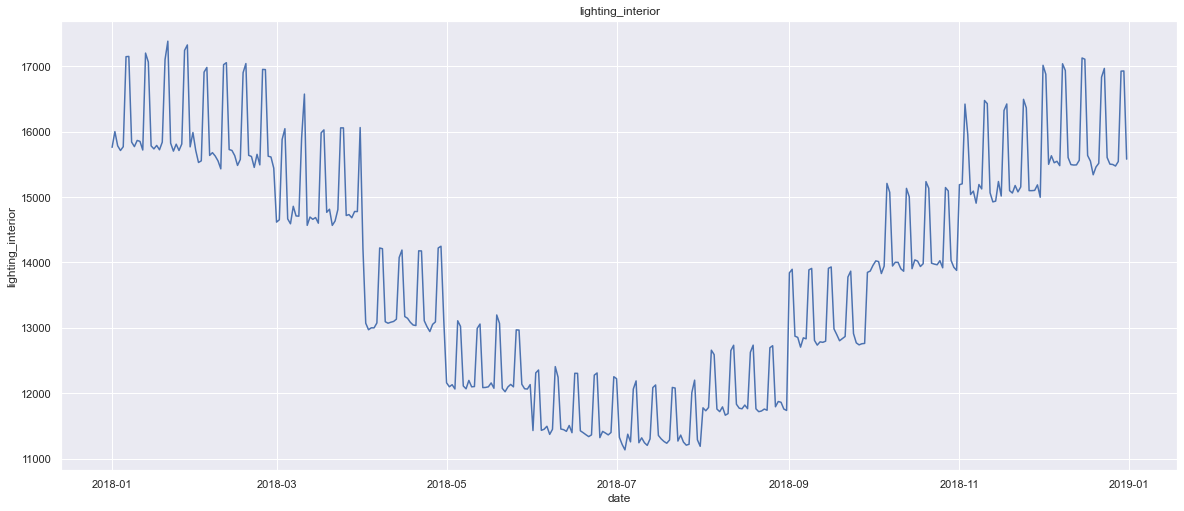

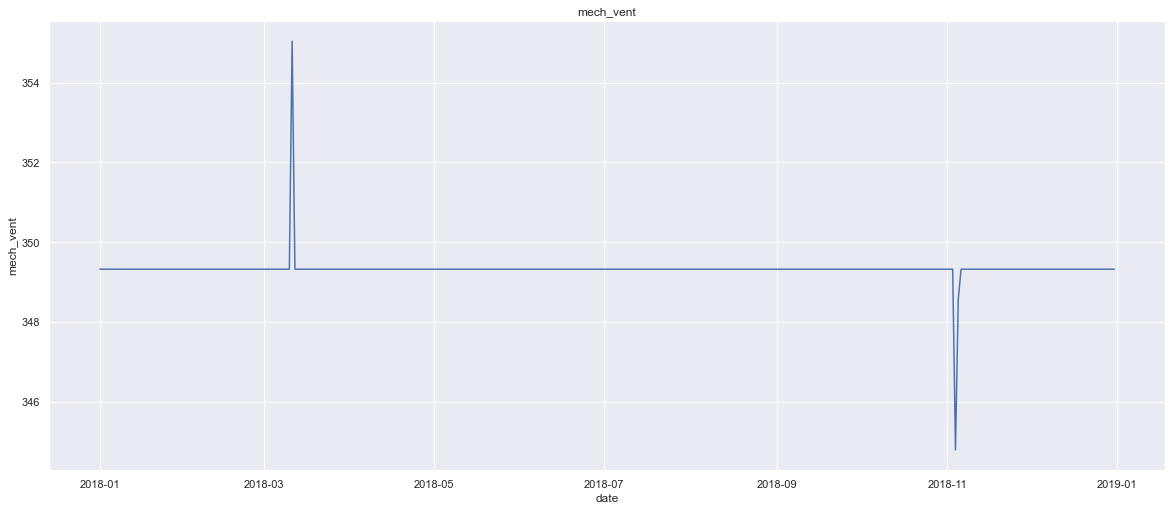

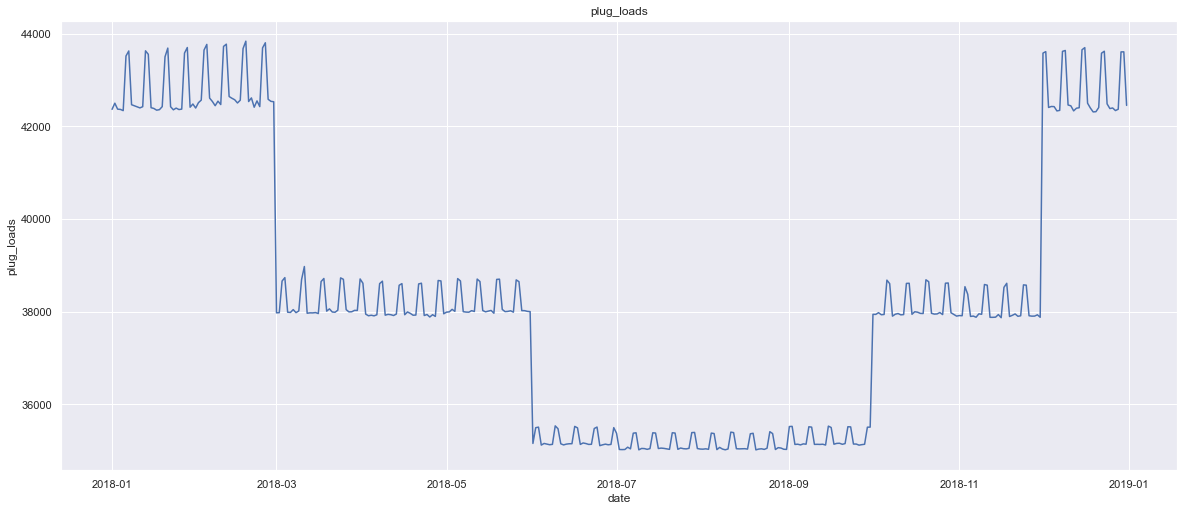

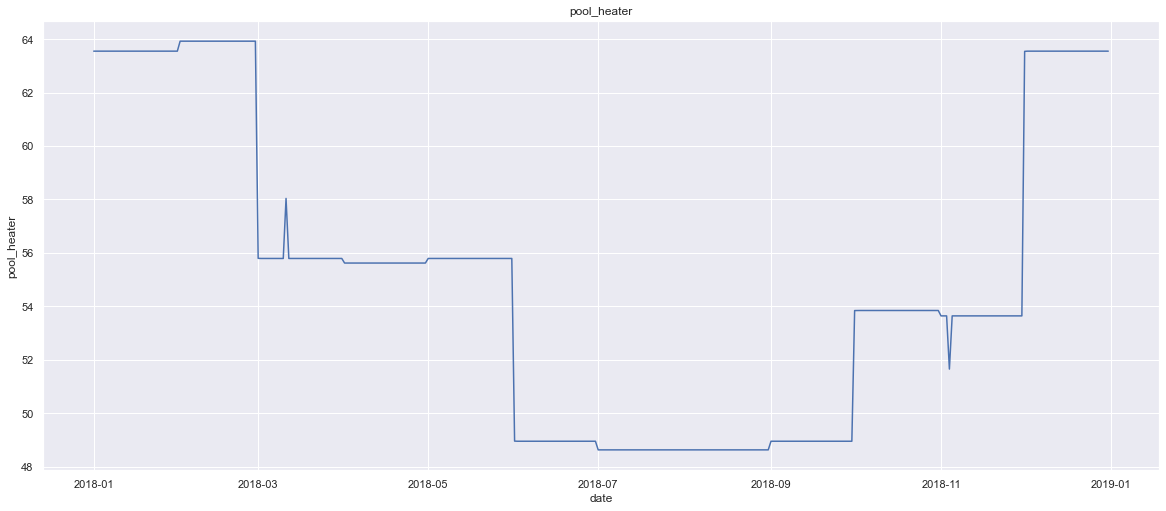

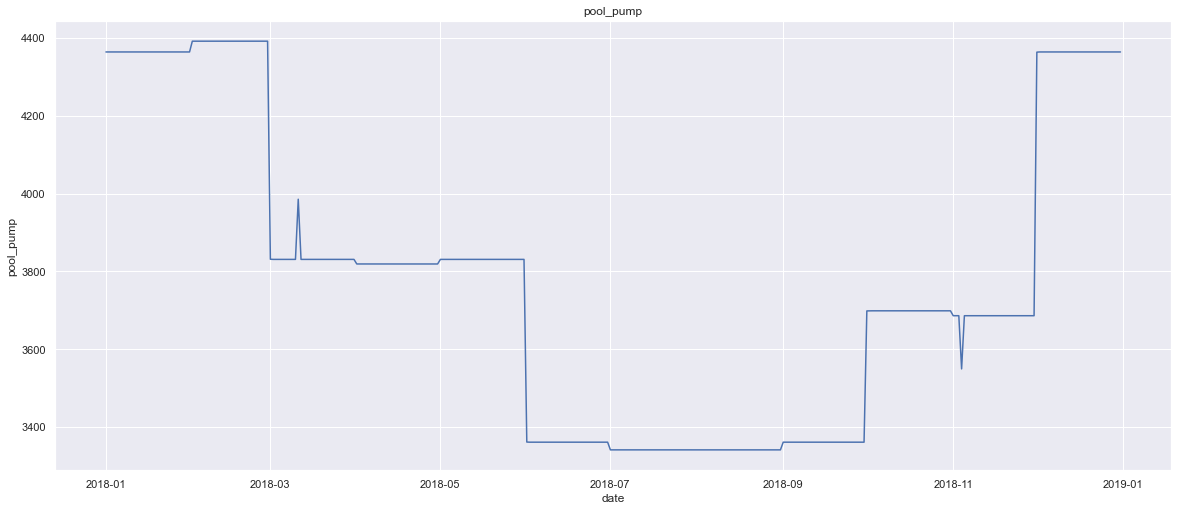

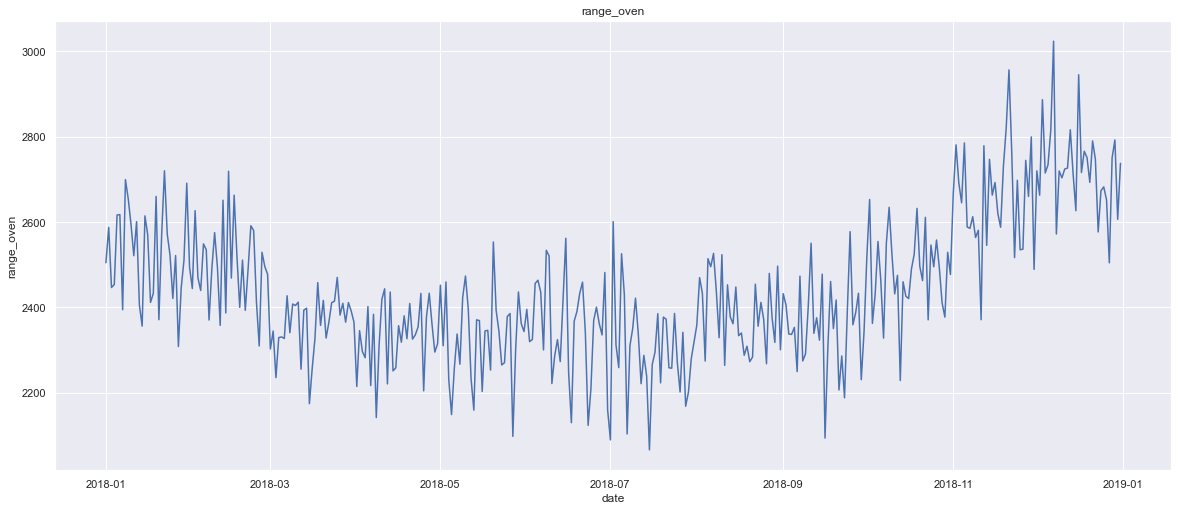

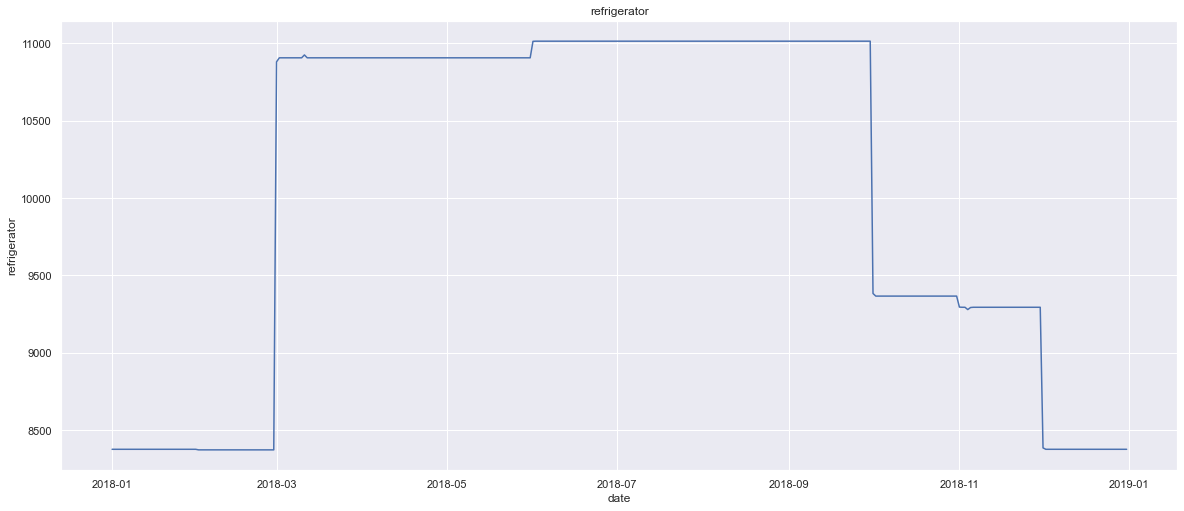

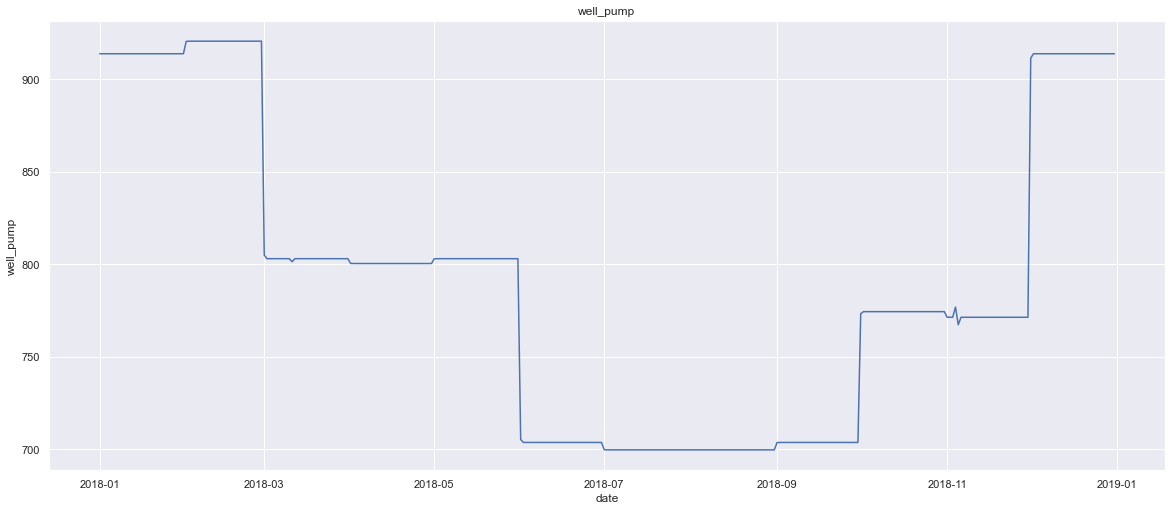

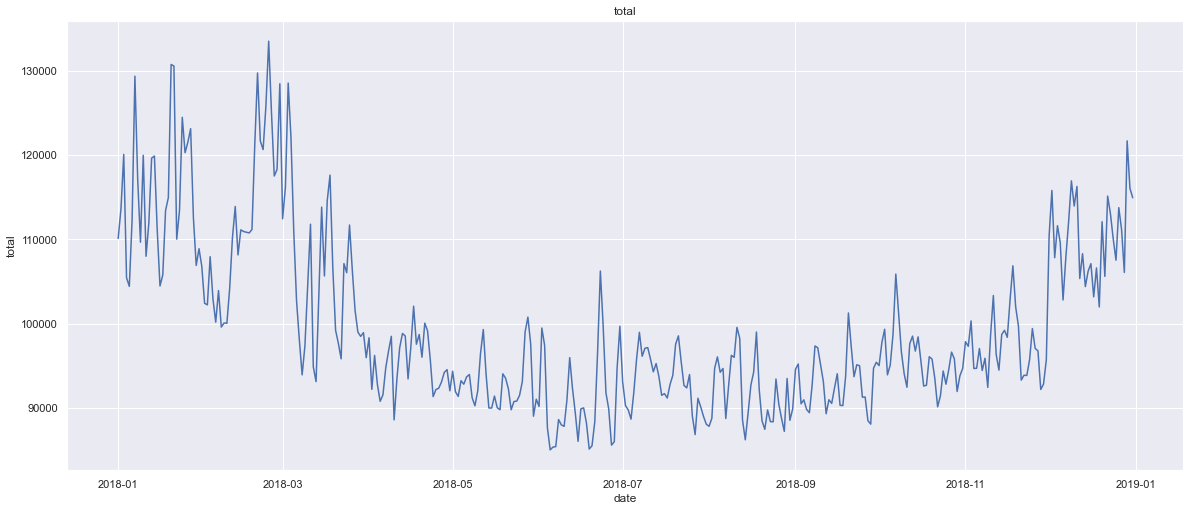

In [199]:

for i in range(len(group_by_day.columns) - 2):
    y_vals = group_by_day.iloc[:, i]
    sns.lineplot(x=group_by_day["date"], y=y_vals)
    plt.title(group_by_day.columns[i])
    plt.show();